# RERF

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lineartree import LinearForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from joblib import dump
import numpy as np

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

In [2]:
train =  pd.read_parquet('../../../data/model_input/train_sets/superconductivity.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/superconductivity.parquet')

In [3]:
y_train = train.critical_temp
X_train = train.drop(columns=['critical_temp'])

In [4]:
y_validation = validation.critical_temp
X_validation = validation.drop(columns=['critical_temp'])

In [7]:
scaler = StandardScaler().fit(X_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
exploratory_depths = [1, 10, 20, 30, 40]
exploratory_estimators = [5, 10, 20, 30, 50, 100]

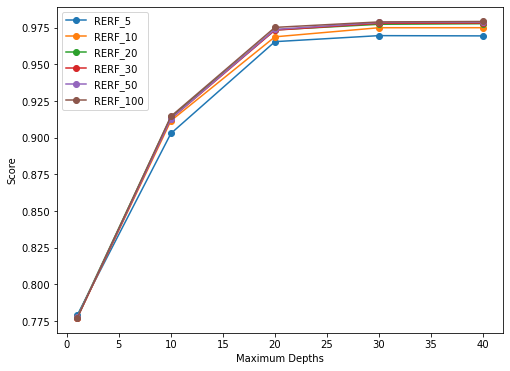

In [11]:
plt.figure(figsize=(8, 6))

for n in exploratory_estimators:
    plt.plot(exploratory_depths, [LinearForestRegressor(base_estimator=LinearRegression(), n_estimators=n, max_features='sqrt', max_depth=i).fit(X_train_scaled, y_train).score(X_train_scaled, y_train) for i in exploratory_depths], 
             marker= 'o', label='RERF_'+str(n))
    
plt.xlabel('Maximum Depths')
plt.ylabel('Score')
plt.legend()
plt.show()

In [12]:
max_depth = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
n_estimators = [5, 10, 15, 20]
base_est = [LinearRegression(), Ridge(), Lasso(), ElasticNet(l1_ratio=0.25), ElasticNet(l1_ratio=0.5), ElasticNet(l1_ratio=0.75)]

In [13]:
models_list = []
for n in n_estimators:
    for i in max_depth:
        for est in base_est:
            models_list.append(LinearForestRegressor(base_estimator=est, max_features='sqrt', n_estimators=n, max_depth=i))

In [14]:
names_list = []

for n in n_estimators:
    for depth in max_depth:
        for est in base_est:
            if isinstance(est, LinearRegression):
                name = f'RERF_{depth}_{n}'
            elif isinstance(est, Ridge):
                name = f'RERF_{depth}_{n}_l2'
            elif isinstance(est, Lasso):
                name = f'RERF_{depth}_{n}_l1'
            elif isinstance(est, ElasticNet):
                name = f'RERF_{depth}_{n}_en_{est.l1_ratio}'
            else:
                raise ValueError('Unknown base estimator type')
            
            names_list.append(name)

In [16]:
metrics = regression(models_list, names_list, '../../../data/model_output/metrics/superconductivity/rerf.csv', X_train_scaled, y_train, X_validation_scaled, y_validation, metrics={})
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
RERF_1_5,0.169738,16.210177,52.655942,224.832613
RERF_1_5_l2,0.092711,16.157142,51.152105,216.591289
RERF_1_5_l1,0.302434,18.097876,34.727092,91.884906
RERF_1_5_en_0.25,1.233773,18.428915,32.120503,74.294051
RERF_1_5_en_0.5,1.047851,18.501665,32.436252,75.315314
...,...,...,...,...
RERF_30_20_l2,2.819842,5.156925,49.579730,861.420360
RERF_30_20_l1,2.853788,5.115498,31.106355,508.080672
RERF_30_20_en_0.25,3.913150,5.117545,28.125776,449.595102
RERF_30_20_en_0.5,4.049351,5.097355,28.325008,455.680460


In [47]:
metrics.sort_values(by='Validation_RMSE')

,Run_Time,Train_RMSE,Validation_RMSE,delta%
RERF_25_20_en_0.25,3.594867,5.099226,27.892516,446.995080
RERF_15_20_en_0.25,2.850080,6.293946,27.942664,343.960937
RERF_15_5_en_0.25,1.564926,6.811405,27.956538,310.437192
RERF_30_15_en_0.25,3.109203,5.164854,27.964680,441.441860
RERF_25_15_en_0.25,3.104212,5.167835,28.021095,442.221153
...,...,...,...,...
RERF_2_5,0.270783,15.829699,52.596731,232.266139
RERF_1_10,0.192759,16.135442,52.635488,226.210397
RERF_1_15,0.244287,16.166611,52.648236,225.660316
RERF_1_20,0.336570,16.179197,52.653276,225.438127


We choose **RERF_25_20_en_0.25** because it looks overfitted but we need deep trees for better predictions (visual deduction from another graphs)

In [5]:
test =  pd.read_parquet('../../../data/model_input/test_sets/superconductivity.parquet')

In [6]:
y_test = test.critical_temp
X_test = test.drop(columns=['critical_temp'])

In [7]:
retrain = pd.concat([train, validation])

In [8]:
y_retrain = retrain.critical_temp
X_retrain = retrain.drop(columns=['critical_temp'])

In [9]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [10]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [48]:
model = LinearForestRegressor(base_estimator=ElasticNet(l1_ratio=0.25), max_depth=25, n_estimators=20, max_features='sqrt').fit(X_retrain_scaled, y_retrain)

In [49]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 9.8433


In [50]:
dump(model, '../../../data/model_output/models/superconductivity/best_rerf.joblib')

['best_rerf.joblib']

In [51]:
with open('../../../data/model_output/metrics/superconductivity/final_RMSE.txt', 'a') as f:
    f.write('\nRERF, '+ str(rmse))

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_13824/2336408728.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],


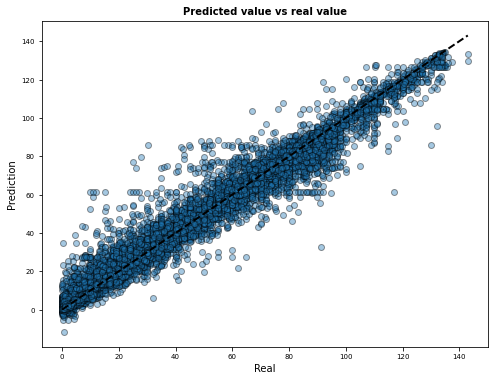

In [52]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)

In [11]:
from joblib import load
load_mod = load('../../../data/model_output/models/superconductivity/best_rerf.joblib')

train_pred = load_mod.predict(X_retrain_scaled)
rmse_train = root_mean_squared_error(y_retrain, train_pred)
test_pred = load_mod.predict(X_test_scaled)
rmse_test = root_mean_squared_error(y_test, test_pred)

In [12]:
import time 
time1 = time.time()
LinearForestRegressor(base_estimator=ElasticNet(l1_ratio=0.25), max_depth=25, n_estimators=20, max_features='sqrt').fit(X_retrain_scaled, y_retrain)
time2 = time.time() - time1 

with open('../../../data/model_output/metrics/superconductivity/final_metrics.txt', 'a') as f:
     f.write(f'\nRERF; {time2}; {rmse_train}; {rmse_test}')